## Customer Churn Analytics - Model Training

We will be working with three tables that contains Customer data, Communications data and Order data for a Retail Store. These dataset can be used to understand the consumer behaviour to predict churn, in this example.

These datasets were generated for this demo using a Kaggle dataset below.

Reference: https://www.kaggle.com/uttamp/store-data


In this notebook, we will work with the CURATED_CUSTOMER_CHURN table that is created by the Feature Engineering notebook and train a classification model using XGBoost to predict customer churn.

In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
import snowflake.snowpark.types as T
import preprocessing as pp
from snowflake.snowpark.functions import sproc, col
import json
import matplotlib.pyplot as plt
import io
import joblib
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

## 1. Create a Snowpark Session


In [2]:
with open('creds.json') as f:
        data = json.load(f)
        connection_parameters = {
          'account': data['account'],
          'user': data['user'],
          'password': data['password'], #getpass.getpass(),
          'schema': data['schema'],
          'database': data['database'],
          'warehouse': data['warehouse']}
session = Session.builder.configs(connection_parameters).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

[Row(CURRENT_WAREHOUSE()='BI_MEDIUM_WH', CURRENT_DATABASE()='SUMMIT_DB', CURRENT_SCHEMA()='CHURN')]


In [3]:
session.add_import('preprocessing')
session.add_packages('snowflake-snowpark-python','scipy', 'scikit-learn', 'pandas', 'numpy', 'joblib', 'xgboost', 'cachetools')

## 2. Create stages for models and udfs


In [4]:
query = "create or replace stage models" +\
        " directory = (enable = true)" +\
        " copy_options = (on_error='skip_file')"
        
session.sql(query).collect()

[Row(status='Stage area MODELS successfully created.')]

In [5]:
query = "create or replace stage udf" +\
        " copy_options = (on_error='skip_file')"
        
session.sql(query).collect()

[Row(status='Stage area UDF successfully created.')]

In [6]:
def save_file(session, model, path):
  input_stream = io.BytesIO()
  joblib.dump(model, input_stream)
  session._conn._cursor.upload_stream(input_stream, path)
  return "successfully created file: " + path

## 3. Feature Engineering and XGBoost Model Training in Python Stored Procedures


First, we will do feature engineering to add new features, drop features and apply one-hot encoding to categorical fields.

In [7]:
src_table_name = 'TRANSFORMED_CUSTOMER_CHURN'
tgt_table_name = 'CURATED_CUSTOMER_CHURN'

def preprocessData(dfRaw):
 
    dfTransformed = dfRaw.drop(dfRaw["CREATED_DT"],dfRaw["FIRST_ORDER_DT"],dfRaw["LAST_ORDER_DT"])
    encoder_input_cols = ["FAV_DELIVERY_DAY", "CITY"]
    ohe = pp.OneHotEncoder(input_cols=encoder_input_cols)
    ohe.fit(dfTransformed)
    ohe_dfTransformed = ohe.transform(dfTransformed)
    return ohe_dfTransformed

def dataPrep(session: Session) -> str:
    src_df = session.table(src_table_name)
    df=preprocessData(src_df)
    df.write.mode("overwrite").save_as_table(tgt_table_name)
    return 'SUCCESS'

# Create an instance of StoredProcedure using the sproc() function
data_prep_sp = sproc(dataPrep, replace=True)

In [8]:
data_prep_sp()

'SUCCESS'

![Original Data Frame](images/image1.png)

<AxesSubplot:xlabel='RETAINED'>

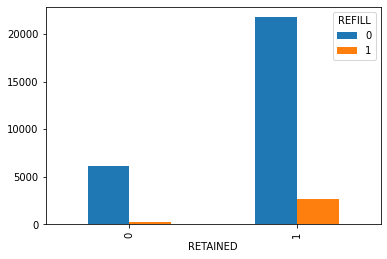

In [9]:
#plot refill against customers retained
df_retained = session.table(tgt_table_name).select('CUSTOMER_ID','RETAINED','REFILL')\
             .group_by(col('RETAINED'), col('REFILL')) \
             .count() \
             .toPandas()

pd.pivot_table(df_retained,
              values='COUNT',
              index='RETAINED',
              columns='REFILL') \
             .plot.bar()

In [10]:
def train_model(session: Session) -> str:
    snowdf = session.table(tgt_table_name).drop('CUSTOMER_ID')
    # split the train and test set
    snowdf_train, snowdf_test = snowdf.random_split([0.8, 0.2], seed=82) # use seed to make the split repeatable
    

    # save the train and test sets as time stamped tables in Snowflake 
    snowdf_train.write.mode("overwrite").save_as_table(tgt_table_name + "_TRAIN")
    snowdf_test.write.mode("overwrite").save_as_table(tgt_table_name +"_TEST")
    
    
   
        # Imputing missing values in numeric columns
    numeric_types = [T.DecimalType, T.LongType, T.DoubleType, T.FloatType, T.IntegerType]
    numeric_columns = [c.name for c in snowdf.schema.fields if type(c.datatype) in numeric_types]
    categorical_columns = [c.name for c in snowdf.schema.fields if type(c.datatype) not in numeric_types]
    for column in numeric_columns:
        snowdf = snowdf.fillna(snowdf.select(F.median(column)).collect()[0][0], column)
        
    cust = snowdf_train.drop("RETAINED").to_pandas() # drop labels for training set
    cust_labels = snowdf_train.select("RETAINED").to_pandas()
    cust_test = snowdf_test.drop("RETAINED").to_pandas()
    cust_test_labels = snowdf_test.select("RETAINED").to_pandas()
    

    standardizer = StandardScaler()
  
    xgbc_classifier = XGBClassifier(
          colsample_bytree=0.6621869047211867,
          learning_rate=0.006344788828608473,
          max_depth=6,
          min_child_weight=8,
          n_estimators=1115,
          n_jobs=100,
          subsample=0.26613420034295865,
          verbosity=0,
          random_state=829929877,
          nthread=1
    )
    
 
    full_pipeline = Pipeline([
            ('standardizer', standardizer),
            ('classfier', xgbc_classifier)
        ])

    # fit the preprocessing pipeline and the model together
    full_pipeline.fit(cust, cust_labels)
    
    y_pred = full_pipeline.predict_proba(cust_test)[:,1]
    predictions = [round(value) for value in y_pred]
    balanced_accuracy =  balanced_accuracy_score(cust_test_labels, predictions)
    print("Model testing completed.\n   - Model Balanced Accuracy: %.2f%%" % (balanced_accuracy * 100.0))
    
    
    #Confusion Matrix
    cm = confusion_matrix(cust_test_labels, predictions)
    TN, FP, FN, TP = confusion_matrix(cust_test_labels, predictions).ravel()
    accuracy =  (TP+TN) /(TP+FP+TN+FN)

    
    # save the full pipeline including the model
    save_file(session, full_pipeline, "@MODELS/cust_churn.joblib")

     
    return accuracy

# Create an instance of StoredProcedure using the sproc() function
train_model_sp = sproc(train_model, replace=True)

In [11]:
train_model_sp()

'0.9603148024112526'

## 4. Model Inference - Creating a predict() UDF


In [12]:
import sys
import cachetools
import os
from snowflake.snowpark.functions import udf
session.add_import("@MODELS/cust_churn.joblib")  

@cachetools.cached(cache={})
def read_file(filename):
       import_dir = sys._xoptions.get("snowflake_import_directory")
       if import_dir:
              with open(os.path.join(import_dir, filename), 'rb') as file:
                     m = joblib.load(file)
                     return m

features = ['ESENT', 'EOPENRATE', 'ECLICKRATE', 'PAPERLESS', 'AVG_ORDER', 'DOOR_DELIVERY', 'REFILL', 'DIFF_BETWEEN_LAST_FIRST_DAYS',
              'DIFF_BETWEEN_FIRST_CREATED_DAYS', 'FAV_DELIVERY_DAY_FRIDAY', 'FAV_DELIVERY_DAY_MONDAY', 'FAV_DELIVERY_DAY_SATURDAY', 'FAV_DELIVERY_DAY_SUNDAY', 'FAV_DELIVERY_DAY_THURSDAY',
              'FAV_DELIVERY_DAY_TUESDAY','FAV_DELIVERY_DAY_WEDNESDAY', 'CITY_AUSTIN', 'CITY_DALLAS', 'CITY_HOUSTON', 'CITY_WACO' ]

@udf(name="predict", is_permanent=True, stage_location="@udf", replace=True)
def predict(ESENT: float, EOPENRATE: float, ECLICKRATE: float, PAPERLESS: float, AVGORDER: float, DOORSTEP: int , REFILL: int, DIFF_BETWEEN_LAST_FIRST_DAYS: int,
              DIFF_BETWEEN_FIRST_CREATED_DAYS: int, FAVDAY_FRIDAY: int, FAVDAY_MONDAY:int , FAVDAY_SATURDAY: int, FAVDAY_SUNDAY: int, FAVDAY_THURSDAY: int,
              FAVDAY_TUESDAY: int, FAVDAY_WEDNESDAY: int, CITY_AUSTIN: int, CITY_DALLAS: int, CITY_HOUSTON: int, CITY_WACO: int) -> int:
       m = read_file('cust_churn.joblib')       
       row = pd.DataFrame([locals()], columns=features)
       return m.predict(row)[0]

## 5. Create a prediction table


In [13]:
from snowflake.snowpark import functions as F

pred_table_name="CHURN_PREDICTIONS"

snowdf_test = session.table(tgt_table_name).drop('CUSTOMER_ID')
inputs = snowdf_test.drop("RETAINED")
snowdf_results = snowdf_test.select(*inputs,
                    predict(*inputs).alias('PREDICTION'), 
                    (F.col('RETAINED')).alias('ACTUAL_LABEL')
                    ).limit(20)

snowdf_results.write.mode("overwrite").save_as_table(pred_table_name)

snowdf_results.to_pandas().head(20)

,REFILL,DOOR_DELIVERY,PAPERLESS,ESENT,EOPENRATE,ECLICKRATE,AVG_ORDER,DIFF_BETWEEN_LAST_FIRST_DAYS,DIFF_BETWEEN_FIRST_CREATED_DAYS,FAV_DELIVERY_DAY_FRIDAY,...,FAV_DELIVERY_DAY_SUNDAY,FAV_DELIVERY_DAY_THURSDAY,FAV_DELIVERY_DAY_TUESDAY,FAV_DELIVERY_DAY_WEDNESDAY,CITY_AUSTIN,CITY_DALLAS,CITY_HOUSTON,CITY_WACO,PREDICTION,ACTUAL_LABEL
0,0,0,0,29,100.000000,3.448276,5.32,0,317,0,...,0,0,0,0,0,1,0,0,1,0
1,1,1,1,95,92.631579,10.526316,83.69,-1024,1127,1,...,0,0,0,0,0,1,0,0,1,1
2,0,0,0,0,0.000000,0.000000,33.58,217,59,0,...,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0.000000,0.000000,45.76,0,157,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,30,90.000000,13.333333,111.91,-791,793,0,...,0,0,0,0,0,0,1,0,1,1
5,1,0,1,46,80.434783,15.217391,175.10,-1190,1884,0,...,0,0,0,1,0,1,0,0,1,1
6,1,0,0,60,43.333333,6.666667,116.55,-976,1088,1,...,0,0,0,0,0,0,1,0,1,1
7,1,0,1,64,28.125000,15.625000,68.10,-848,1504,1,...,0,0,0,0,0,1,0,0,1,1
8,0,0,0,45,0.000000,0.000000,37.40,0,52,0,...,0,0,0,1,0,1,0,0,1,1
9,0,0,1,34,94.117647,8.823529,66.07,-1024,1077,0,...,0,0,0,0,0,1,0,0,1,1
